# Objetivo
Analizar el comportamiento de las publicaciones de tv 4k con descuento a lo largo de 4 sites de Mercado Libre.

El objetivo es entender que variables impactan en la venta de la publicación para luego modelar en torno a ellas.
Para esto, realizaremos un análisis exploratorio con los resultados de la api de búsquedas de mercado libre (ej: https://api.mercadolibre.com/sites/MLA/search?q=tv%204k).

En términos de procesamiento, se ejecuta una pipeline que extrae consultas paginadas de la API de 4 sites, almacenando en json los resultados.
Luego, centralizamos en formato parquet los archivos descargados de todas las paginas y todos los sites en una sola tabla, a modo de facilitar el trabajo de exploración.

! Notas
Para ejecutar este notebook, se debe ejecutar previamente la pipeline extraccion datos


# campos importantes
## categoricos:
- listing_type_id (categoria cliente?)
- buying_mode (modo compra)
- site_id (jerarquia sitio web)
- category_id (categoria producto?)
- domain_id (?)
- currency_id (tipo moneda)
- official_store_id (que son tiendas oficiales?)

## numericos:
- currency_id
- order_backend (orden productos web) -> son los primeros productos los mas vendidos? quienes tienen mas stock?
- price (precio a la fecha de consulta)
- original_price (con esta columna != null vemos descuentos)
- sale_price (?)
- sold_quantity (articulos vendidos)
- available_quantity (articulos disponibles)

## booleanos:
- accepts_mercadopago

## timestamp:
- stop_time (tiempo finalización publicación)

## diccionarios:
- tags (otras descripciones - jerarquias a investigar)
- seller (otras jerarquias a investigar)
- seller_address (direccion para jerarquia paises, ej: ciudad)
- address (idem anterior)
- attributes (investigar)
- installments (investigar)

--notas:
unicos por id ? (MLA1386115404)
catalog_product_id (MLA21728449)
categoria cliente listing_type_id? 

Foco en descuentos
- Analisis comparativo venta categorías por países (análisis demanda meli tecnologia)
- Analisis precios medios por países (llevar a dolar) inflacion?
- Análisis descuentos medios por países y por categorías
- Análisis si lo que tiene mayor descuento vende más
- Análisis tags (wordcloud) para buscar relaciones de productos con descuentos
- Análisis proporción artículos con descuentos vs total
- Análisis penetración mercado pago por regiones / tipos producto / etc
- Le importa a meli el stock de sus clientes?
- Podemos saber que cliente es fraudulento? -> Ítems con pérdida de exposición en https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import ttest_ind
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

# rutas para leer datos de busquedas desde api mercado libre
search_folder = "/workspaces/ecommerce_analysis/data/stage=raw/source=search/dataformat=parquet"
sites_folder = "/workspaces/ecommerce_analysis/data/stage=raw/source=sites/dataformat=parquet"
publications_folder = "/workspaces/ecommerce_analysis/data/stage=raw/source=search_publications/dataformat=parquet"

# diccionario para convertir moneda local a dolar
money_conversion = {'ARS': 0.0043,
                    'BRL': 0.2,
                    'CLP': 0.0013,
                    'PEN': 0.27}

# lectura tablas a trabajar
search_results = pd.read_parquet(search_folder, engine="pyarrow")
sites = pd.read_parquet(sites_folder, engine="pyarrow")
total_publications = pd.read_parquet(publications_folder, engine="pyarrow")

with pd.option_context('display.max_columns', None,):
    display(search_results.head())
    display(sites)
    display(total_publications)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,sold_quantity,available_quantity,official_store_id,official_store_name,use_thumbnail_id,accepts_mercadopago,tags,shipping,stop_time,seller,seller_address,address,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,variation_id,variation_filters,variations_data
0,MLA1401638692,Smart Tv Telefunken 50 4k Tk5022 Sintonizador ...,new,750802-MLA69301030669_052023,MLA22326427,gold_special,https://www.mercadolibre.com.ar/smart-tv-telef...,buy_it_now,MLA,MLA1002,MLA-TELEVISIONS,http://http2.mlstatic.com/D_750802-MLA69301030...,ARS,1,99999.0,135999.0,None,100,150,1938.0,Mercado Libre Electronica,True,True,"[ahora-paid-by-buyer, extended_warranty_eligib...","{'free_shipping': True, 'logistic_type': 'fulf...",2043-04-30T15:28:58.000Z,"{'_': False, 'car_dealer': False, 'car_dealer_...","{'address_line': '', 'city': {'id': None, 'nam...","{'city_id': None, 'city_name': 'Villa Celina',...","[{'attribute_group_id': 'MAIN', 'attribute_gro...","{'amount': 18083.99, 'currency_id': 'ARS', 'qu...",None,True,None,[],CXJN21048,None,None,None,None
1,MLA1364904537,Smart Tv Kodak We-6xst005 4k 60 220v,new,981544-MLA53227715351_012023,MLA21076857,gold_special,https://www.mercadolibre.com.ar/smart-tv-kodak...,buy_it_now,MLA,MLA1002,MLA-TELEVISIONS,http://http2.mlstatic.com/D_981544-MLA53227715...,ARS,2,127999.0,200000.0,None,50,1,NaN,None,True,True,"[ahora-paid-by-buyer, deal_of_the_day, extende...","{'free_shipping': False, 'logistic_type': 'def...",2043-03-31T04:00:00.000Z,"{'_': False, 'car_dealer': False, 'car_dealer_...","{'address_line': '', 'city': {'id': None, 'nam...","{'city_id': None, 'city_name': 'Garín', 'state...","[{'attribute_group_id': 'MAIN', 'attribute_gro...","{'amount': 23147.55, 'currency_id': 'ARS', 'qu...",None,True,None,[],None,None,None,None,None
2,MLA1156297648,Smart Tv Tcl C72-series 50c725 Qled Android Pi...,new,613322-MLA53779631053_022023,MLA18597975,gold_special,https://www.mercadolibre.com.ar/smart-tv-tcl-c...,buy_it_now,MLA,MLA1002,MLA-TELEVISIONS,http://http2.mlstatic.com/D_613322-MLA53779631...,ARS,3,147399.0,NaN,None,5,1,1425.0,Diggit,True,True,"[ahora-paid-by-buyer, extended_warranty_eligib...","{'free_shipping': True, 'logistic_type': 'fulf...",2042-09-21T18:15:41.000Z,"{'_': False, 'car_dealer': False, 'car_dealer_...","{'address_line': '', 'city': {'id': None, 'nam...","{'city_id': None, 'city_name': 'Garin', 'state...","[{'attribute_group_id': 'MAIN', 'attribute_gro...","{'amount': 26655.88, 'currency_id': 'ARS', 'qu...",None,True,None,[],NZKJ32770,None,None,None,None
3,MLA1297400226,Smart Noblex 50 91dk50x6550 4k Sistema Vidaa,new,795066-MLA51934174412_102022,MLA20005522,gold_special,https://www.mercadolibre.com.ar/smart-noblex-5...,buy_it_now,MLA,MLA1002,MLA-TELEVISIONS,http://http2.mlstatic.com/D_795066-MLA51934174...,ARS,4,101999.0,164999.0,None,200,200,1372.0,Mall 360,True,True,"[deal_of_the_day, extended_warranty_eligible, ...","{'free_shipping': True, 'logistic_type': 'cros...",2043-05-03T02:40:59.000Z,"{'_': False, 'car_dealer': False, 'car_dealer_...","{'address_line': '', 'city': {'id': None, 'nam...","{'city_id': None, 'city_name': 'Monte Chingolo...","[{'attribute_group_id': 'MAIN', 'attribute_gro...","{'amount': 18445.67, 'currency_id': 'ARS', 'qu...",None,True,None,[],BKXX23261,None,None,None,None
4,MLA1148941757,Smart Tv Samsung Series 7 Un55au7000gczb Led T...,new,739692-MLA48913871021_012022,MLA18718085,gold_pro,https://www.mercadolibre.com.ar/smart-tv-samsu...,buy_it_now,MLA,MLA1002,MLA-TELEVISIONS,http://http2.mlstatic.com/D_739692-MLA48913871...,ARS,5,175999.0,219999.0,None,500,250,1938.0,Mercado Libre Electronica,True,True,"[extended_warranty_eligible, good_quality_pict...","{'free_shipping': True, 'logistic_type': 'fulf...",2042-11-25T18:00:04.000Z,"

,default_currency_id,id,name
0,COP,MCO,Colombia
1,HNL,MHN,Honduras
2,VES,MLV,Venezuela
3,CLP,MLC,Chile
4,GTQ,MGT,Guatemala
5,BRL,MLB,Brasil
6,CRC,MCR,Costa Rica
7,CUP,MCU,Cuba
8,PYG,MPY,Paraguay
9,DOP,MRD,Dominicana


,total,primary_results,offset,limit,site
0,3474,1000,0,50,MLA
0,3145,1000,0,50,MLB
0,663,663,0,50,MLC
0,899,899,0,50,MPE


In [2]:
# renombramos publicaciones totales para cruce posterior
total_publications = total_publications[['site', 'total']]
total_publications.columns = ['site_id', 'total_publications']

# creamos variable "tiene descuento" como boolean
search_results['has_discount'] = search_results['original_price']\
    .apply(lambda x: 0 if pd.isna(x) else 1)
# creamos variable "porcentaje descuento"
search_results['discount_percentage'] = search_results\
    .apply(lambda x: x['price']/x['original_price'] - 1 if (x['has_discount']==1) and (~pd.isna(x['price'])) else 0, axis=1)
# creamos variable precio en dolar usando diccionario en duro
# TODO: extraer conversión desde servicio
search_results['price_usd'] = search_results.apply(lambda x: x['price'] * money_conversion[x['currency_id']] if x['currency_id']!='USD' else x['price'], axis=1)

# definimos funcion que hace join entre tablas para chequear integridad del cruce
def search_with_total_publications():
    return search_results.merge(total_publications, left_on=['site_id'], right_on=['site_id'], how='left')

assert len(search_results) == len(search_with_total_publications())

search_results = search_with_total_publications()

# agrupamos resultados por categoria
results_grouped = search_results\
    .groupby('category_id')\
    .agg({'sold_quantity': 'sum',
          'has_discount': 'sum'})\
    .reset_index()

results_grouped.columns = ['category_id', 'sold_quantity_total', 'has_discount_total']

In [3]:
# normalizamos variables por cantidad de publicaciones en el site
columns_to_normalize = ['sold_quantity']

for col in columns_to_normalize:
    # dividimos en 1000 el total de publicaciones para mejor visualizacion
    search_results[f'{col}_norm'] = search_results[col] / (search_results[f'total_publications']/1000)


### ¿Como se distribuyen las publicaciones por site?
Es importante entender el comportamiento de cada sitio, pues cada cual no tendrá el mismo peso en torno a las decisiones que podamos tomar.
En este caso, MLA y MLB son sitios con más de 3.000 publicaciones cada uno, mientras que MLC y MPE suman menos de 2.000 publicaciones.
Para modelar, es importante tener en mente muestrear estratificadamente en caso de querer que cada site represente la misma probabilidad de ser escogido. O bien, muestrear aleatoriamente en caso de querer buscar que escojamos observaciones con la probabilidad que observamos en el universo de mercado libre.

[Text(0.5, 1.0, 'Cantidad publicaciones por Site')]

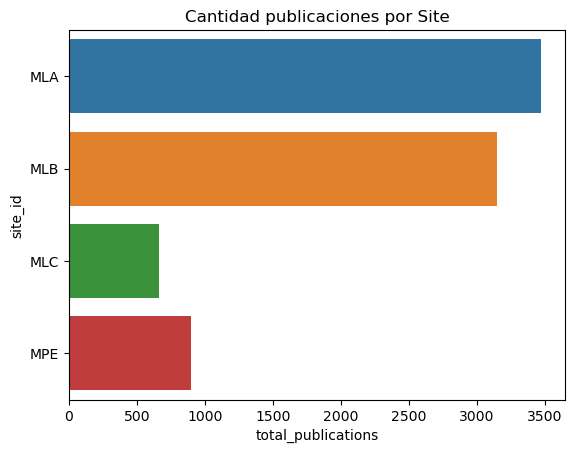

In [4]:
sns.barplot(data=total_publications, x='total_publications', y='site_id')\
    .set(title='Cantidad publicaciones por Site')

### ¿Cómo se distribuyen las publicaciones con descuento por site?
Dado que principalmente buscamos entender como afectan los descuentos a la venta de artículos, podemos observar también si se encuentran presentes de manera balanceada los casos en cada uno de los sites.

[Text(0.5, 1.0, 'Porcentaje publicaciones con descuento por site')]

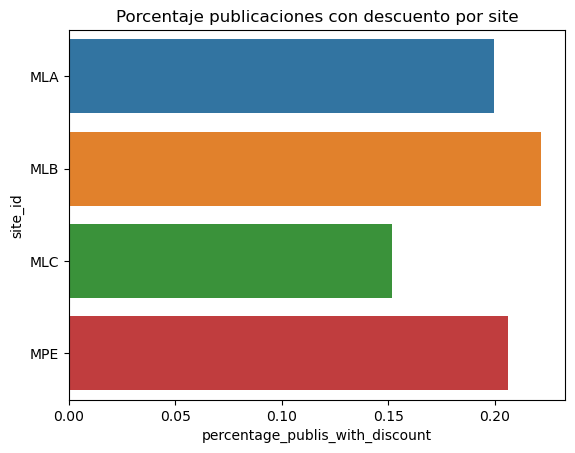

In [5]:
perc_discount_by_site = search_results\
    .groupby(['site_id', 'has_discount'])['total_publications'].count()\
    .reset_index()

perc_discount_by_site['sum_publications'] = perc_discount_by_site.groupby('site_id')['total_publications'].transform('sum')
perc_discount_by_site['percentage_publis_with_discount'] = perc_discount_by_site['total_publications'] / perc_discount_by_site['sum_publications']
perc_discount_by_site

sns.barplot(data=perc_discount_by_site[perc_discount_by_site['has_discount']==1], x='percentage_publis_with_discount', y='site_id')\
    .set(title='Porcentaje publicaciones con descuento por site')

## ¿Cual es la relacion de precios entre sites?
Otro punto relevante de observar es que tan distinta es la realidad local de cada país, donde el precio es una variable relevante de visualizar. Acá, observamos que existe una variación importante de los precios medios en dólares entre las publicaciones observadas, donde esta transformación guarda relación también con la inflación de cada país y los precios en tecnología de ellos

<AxesSubplot:xlabel='price_usd', ylabel='site_id'>

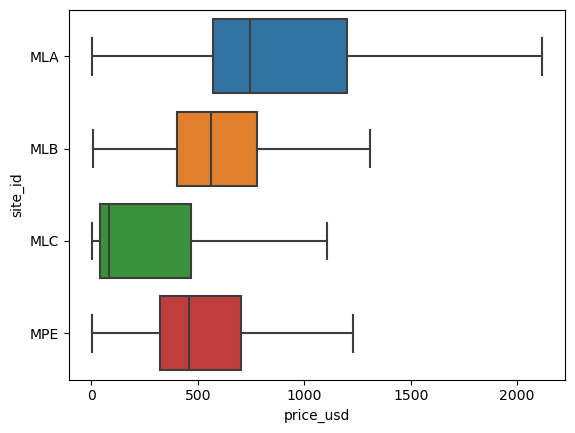

In [6]:
sns.boxplot(data=search_results, x='price_usd', y='site_id', showfliers=False)

A modo general, podemos observar también como se distribuyen los precios en dólares a lo largo de los 4 sites observados, donde la mayor concentración de publicaciones las tenemos entre los 400 y los 800 dólares

<AxesSubplot:xlabel='price_usd', ylabel='Count'>

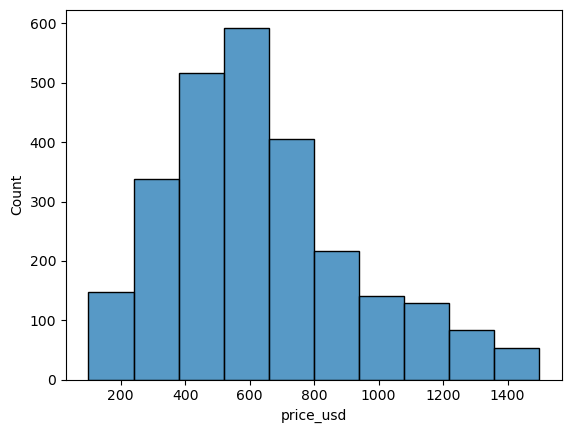

In [7]:
sns.histplot(data=search_results[(search_results['price_usd']>100) & (search_results['price_usd']<1500)], x='price_usd', bins=10)

## ¿Cómo se comporta la cantidad de artículos vendidos por publicación?
Observamos que el site MLB se comporta de una manera muy diferente a los demás, cabe profundizar este caso y buscar una relación entre el tipo de vendedor de este site con los demás.

<AxesSubplot:xlabel='sold_quantity', ylabel='site_id'>

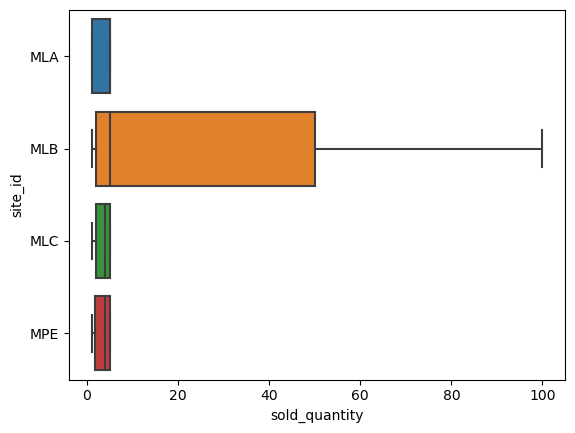

In [24]:
sns.boxplot(data=search_results[search_results['sold_quantity']>0], x='sold_quantity', y='site_id', showfliers=False)

## ¿Como se distribuyen los porcentajes de descuento por sites?
Por otro lado, es importante observar también como se distribuyen los porcentajes de descuento a lo largo de los sites, donde tenemos mayores porcentajes donde tenemos menor cantidad de datos (MLC y MPE). Cabe destacar que MLA posee los menores porcentajes de descuento de los 4 sites.

<AxesSubplot:xlabel='discount_percentage', ylabel='site_id'>

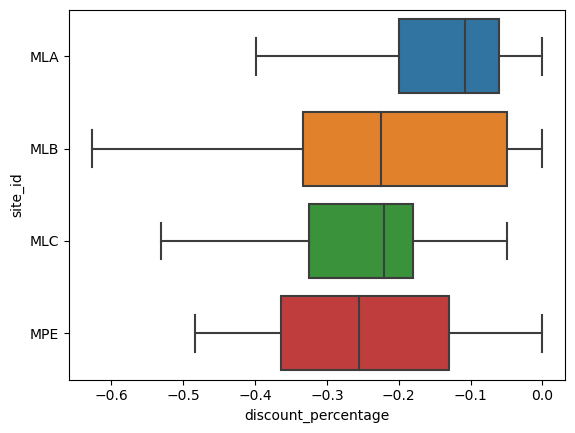

In [9]:
sns.boxplot(data=search_results[search_results['has_discount']==1], x='discount_percentage', y='site_id')

## ¿Cómo es la relación entre las ventas y el precio?
Otra relación interesante de observar es la que tiene el precio con la demanda, pues es posible visualizar comportamientos diferenciados entre publicaciones con descuento y sin descuento.
En particular, podemos observar que las publicaciones con descuento venden ligeramente más que las que no lo tienen.

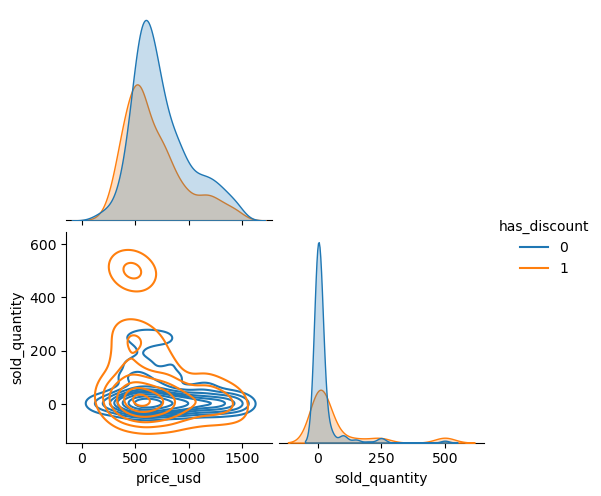

In [26]:
sns.pairplot(data=search_results[(search_results['sold_quantity']>0)
    & (search_results['sold_quantity']<1500)
    & (search_results['price_usd']>100)
    & (search_results['price_usd']<1500)][['price_usd', 'sold_quantity','has_discount']], hue='has_discount', kind='kde', corner=True)

## ¿Publicaciones con descuento venden mas que publicaciones sin descuento?
Esto es confirmable a través de pruebas de hipótesis, donde podemos corroborar si es estadísticamente significativa la media entre dos grupos, o si es mayor uno que otro, etc.
Acá, la idea es probar como hipótesis que la media del primer grupo es mayor que la media del segundo grupo.
El siguiente caso vemos que confirma lo observado.

In [27]:
n_sample = 100
search_results_sample = search_results.sample(n=n_sample, random_state=187)

def hypothesis_test_different_means(group1, group2, n):
    rv = t(df=100-2)

    t_stat, pvalue = ttest_ind(group1, group2, alternative='greater')
    return t_stat, pvalue

hypothesis_test_different_means(search_results_sample[search_results_sample['has_discount']==1]['sold_quantity_norm'], 
                                search_results_sample[search_results_sample['has_discount']==0]['sold_quantity_norm'],
                                n_sample)

(2.7526850754310392, 0.0035220201256342997)

Otra forma de observar el fenómeno, es mediante la comparación de sus distribuciones

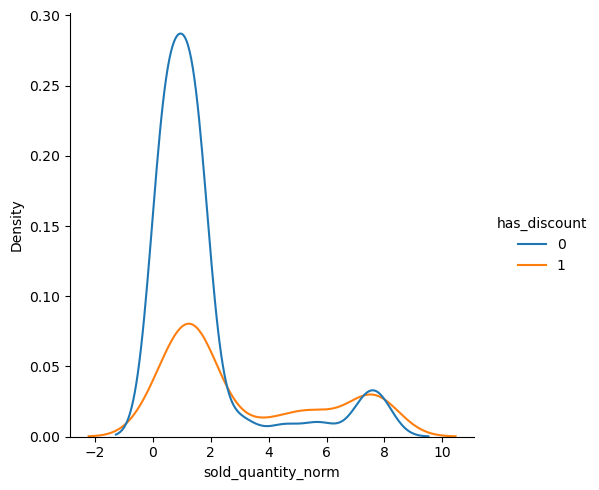

In [12]:
sns.displot(data=search_results[(search_results['sold_quantity_norm']<10)
                                 & (search_results['sold_quantity_norm']>0)], 
            x='sold_quantity_norm', 
            hue='has_discount', 
            kind='kde')

## ¿Permanece este comportamiento por paises?


MLA (1.7521587518148012, 0.04064727721134617)


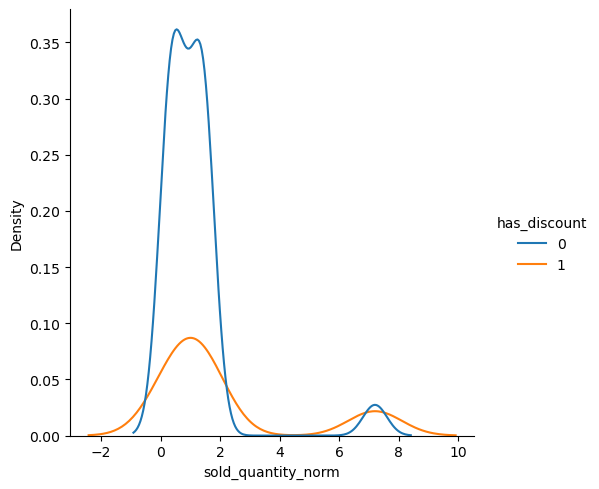

MLB (6.348425892015434, 7.277148128868294e-10)


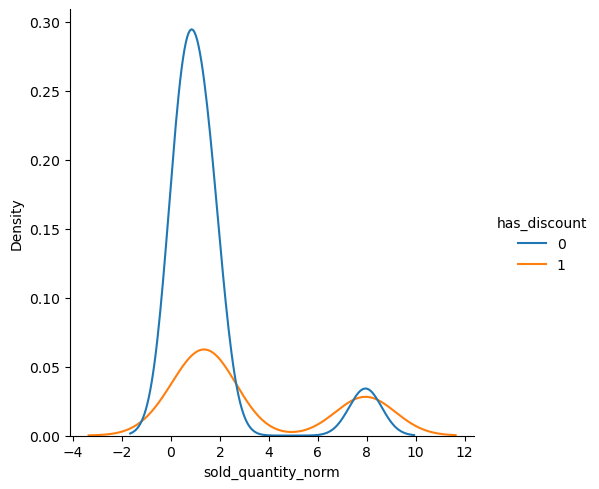

MLC (4.16711731157079, 2.3032919740071974e-05)


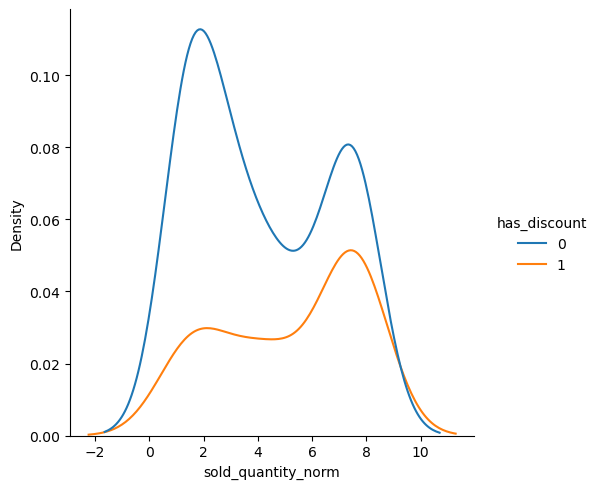

MPE (2.147310027230423, 0.01649211854738951)


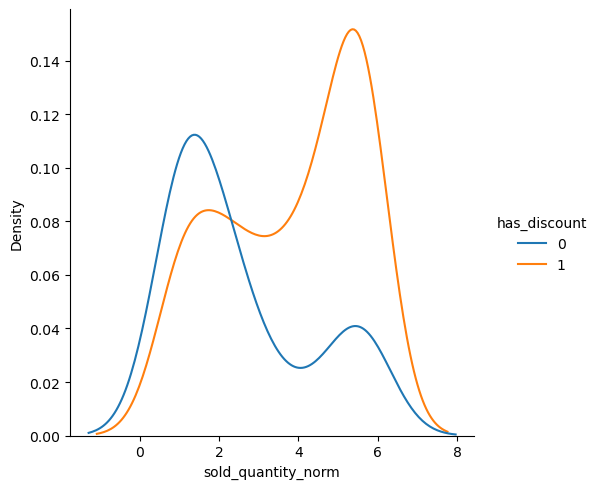

In [13]:
for site_id in ['MLA', 'MLB', 'MLC', 'MPE']:
    n_sample=200
    search_results_sample = search_results[(search_results['site_id']==site_id)].sample(n=n_sample, random_state=187)

    print(site_id, 
          hypothesis_test_different_means(search_results_sample[(search_results_sample['has_discount']==1)]['sold_quantity_norm'], 
                                          search_results_sample[(search_results_sample['has_discount']==0)]['sold_quantity_norm'],
                                          n_sample))
    
    sns.displot(data=search_results[(search_results['sold_quantity_norm']<10) 
                                & (search_results['sold_quantity_norm']>0)
                                & (search_results['site_id']==site_id)], 
                x='sold_quantity_norm', 
                hue='has_discount', 
                kind='kde')
    
    plt.show()

## Reputación más común
Gráfico que representa la reputación de los vendedores (este gráfico se construye a partir de las publicaciones, por lo que vendedores pueden estar repetidos)

<AxesSubplot:title={'center':'Reputacion Vendedores'}, ylabel='None'>

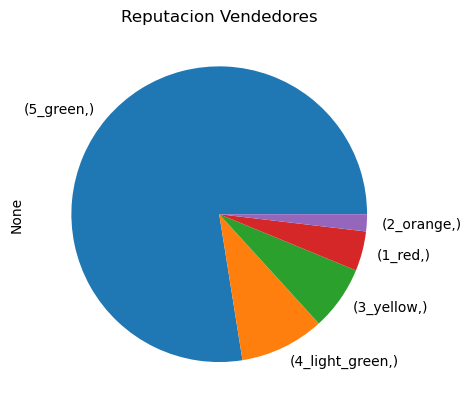

In [47]:
pd.json_normalize(search_results['seller'])[['seller_reputation.level_id']].value_counts().plot(kind='pie', title='Reputacion Vendedores')

## Nube de palabras sobre tags de vendedores
Realizamos un análisis para entender de manera gráfica los conceptos más recurrentes

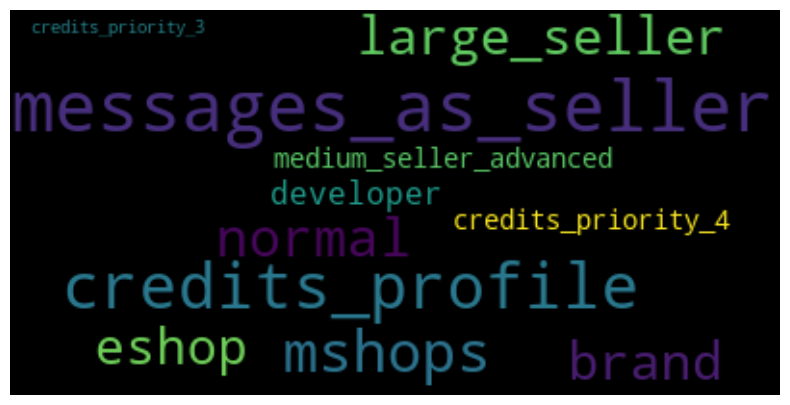

In [38]:
search_results['seller_words'] = pd.json_normalize(search_results['seller'])['tags'].apply(lambda x: " ".join([a for a in x]))

text = " ".join(i for i in search_results['seller_words'])

wordcloud = WordCloud(background_color="black", max_words=1000, max_font_size=50, collocations=False).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
